# Employee Attrition Prediction: Workflow with Real Data

This notebook outlines the end-to-end machine learning workflow used to predict employee attrition, adapted to use the project's real dataset.

## 1. Setup: Importing Libraries

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import shap
import matplotlib.pyplot as plt
import os

pd.options.display.max_columns = None # Show all columns in DataFrames
pd.options.display.max_rows = 100 # Adjust as needed

## 2. Data Loading

In [8]:
DATA_FILE_PATH = 'data/Danh sách nhân sự.xlsx' # Relative path from project root
df_raw = None
try:
    df_raw = pd.read_excel(DATA_FILE_PATH, engine='openpyxl')
    print(f"Successfully loaded data from {DATA_FILE_PATH}")
    print(f"Original Dataset shape: {df_raw.shape}")
except FileNotFoundError:
    print(f"Error: The file {DATA_FILE_PATH} was not found. Please ensure it's in the correct location.")
except Exception as e:
    print(f"Error loading data: {e}")

Successfully loaded data from data/Danh sách nhân sự.xlsx
Original Dataset shape: (8702, 43)


### 2.1. Initial Data Overview (Non-Sensitive Insights)

In [9]:
if df_raw is not None:
    print("--- Basic DataFrame Info ---")
    df_raw.info(verbose=True, show_counts=True)
    
    print("\n--- Percentage of Missing Values per Column (showing top 15 with most missing) ---")
    missing_percentage = (df_raw.isnull().sum() * 100 / len(df_raw)).sort_values(ascending=False)
    print(missing_percentage[missing_percentage > 0].head(15))
    
    print("\n--- Number of Unique Values for Key Categorical Columns ---")
    key_categorical_cols_overview = ['Phòng Ban', 'Chức danh', 'Công Ty', 'Địa Điểm Làm Việc', 'Loại hợp đồng', 'Giới tính', 'Trình độ học vấn'] # Added 'Trình độ học vấn'
    for col in key_categorical_cols_overview:
        if col in df_raw.columns:
            print(f"Unique values in '{col}': {df_raw[col].nunique()}")
            
    print("\n--- Descriptive Statistics for Key Numerical Columns (Original Data) ---")
    key_numerical_cols_overview = ['Thâm niên', 'Tổng Mức Lương', 'Lương BHXH', 'Mức thưởng KPI hoặc Khoán', 'Mức Phụ cấp']
    if 'Độ tuổi' in df_raw.columns and pd.api.types.is_numeric_dtype(df_raw['Độ tuổi']):
        key_numerical_cols_overview.append('Độ tuổi')
        
    existing_key_numerical_cols_overview = [col for col in key_numerical_cols_overview if col in df_raw.columns and pd.api.types.is_numeric_dtype(df_raw[col])]
    if existing_key_numerical_cols_overview:
        print(df_raw[existing_key_numerical_cols_overview].describe().round(2))
    else:
        print("No key numerical columns found or they are not of numeric type in the raw data for initial overview.")
    # To view actual data head (first 5 rows, all columns), uncomment locally:
    # print("\nRaw Data Head (first 5 rows - BE CAREFUL WITH SENSITIVE DATA IF SHARING OUTPUT):")
    # print(df_raw.head())

--- Basic DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8702 entries, 0 to 8701
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Đang làm việc              3022 non-null   object        
 1   Trùng Kiêm nhiệm           11 non-null     object        
 2   Nhóm ngành                 8700 non-null   object        
 3   Nhóm công ty               8700 non-null   object        
 4   Công Ty                    8700 non-null   object        
 5   Khối                       1529 non-null   object        
 6   Phòng Ban                  8700 non-null   object        
 7   Tổ / Bộ phận               5934 non-null   object        
 8   Mã Nhân Viên               8700 non-null   object        
 9   Họ Và Tên                  8700 non-null   object        
 10  Chức vụ                    7105 non-null   object        
 11  Chức danh                  8690 non-null

## 3. Preprocessing Steps (Replicating logic from `preprocessing.py`)
This section will apply the same preprocessing steps as defined in the project's Python scripts.
A dedicated function `preprocess_data_notebook` mirrors the logic from `src/preprocessing.py`.

In [10]:
def preprocess_data_notebook(df_input, is_training_run=True, fitted_preprocessor_objects=None):
    if df_input is None: return (None, None, None, None) if is_training_run else (None, None)
    df_proc = df_input.copy()
    print(f"\n--- Starting Preprocessing in Notebook (is_training_run={is_training_run}) ---")

    y_series = None
    if is_training_run:
        if 'Đang làm việc' not in df_proc.columns: print("Error: Target 'Đang làm việc' not found."); return None,None,None,None
        df_proc['target'] = df_proc['Đang làm việc'].apply(lambda x: 0 if x == 1 or str(x).lower() == '1' else 1)
        y_series = df_proc['target']
        print(f"Target 'target' created. Distribution:\n{y_series.value_counts(normalize=True).round(3)}")
    
    cols_to_drop_nb = ['Đang làm việc', 'Mã Nhân Viên', 'Họ Và Tên', 'Số điện thoại', 'Email', 
                       'Ngày nghỉ việc', 'Lý do nghỉ việc', 'Trùng Kiêm nhiệm', 'Khối', 
                       'Trình độ ngoại ngữ', 'Tin học', 'Ngày kết thúc HĐ', 'Ngày thâm niên']
    df_proc.drop(columns=[col for col in cols_to_drop_nb if col in df_proc.columns], errors='ignore', inplace=True)

    if 'Ngày sinh' in df_proc.columns:
        df_proc['Ngày sinh'] = pd.to_datetime(df_proc['Ngày sinh'], errors='coerce')
        df_proc['Độ tuổi'] = pd.Timestamp('now').year - df_proc['Ngày sinh'].dt.year
        df_proc.drop(columns=['Ngày sinh'], errors='ignore', inplace=True)
    elif 'Độ tuổi' in df_proc.columns: df_proc['Độ tuổi'] = pd.to_numeric(df_proc['Độ tuổi'], errors='coerce')

    date_derived_cols_init = ['Ngày vào làm_Year', 'Ngày vào làm_Month', 'Ngày vào làm_Day',
                              'Ngày kết thúc thử việc_Year', 'Ngày kết thúc thử việc_Month', 'Ngày kết thúc thử việc_Day',
                              'Ngày bắt đầu HĐ_Year', 'Ngày bắt đầu HĐ_Month', 'Ngày bắt đầu HĐ_Day',
                              'ProbationDurationDays']
    for col_init_nb in date_derived_cols_init: 
        if col_init_nb not in df_proc.columns: df_proc[col_init_nb] = np.nan
    
    original_dates_nb = {}
    for col_date_nb, keep_orig_nb in {'Ngày vào làm': True, 'Ngày kết thúc thử việc': True, 'Ngày bắt đầu HĐ': False}.items():
        if col_date_nb in df_proc.columns:
            df_proc[col_date_nb] = pd.to_datetime(df_proc[col_date_nb], errors='coerce')
            if not df_proc[col_date_nb].isnull().all():
                if keep_orig_nb: original_dates_nb[col_date_nb] = df_proc[col_date_nb].copy()
                df_proc[f'{col_date_nb}_Year'] = df_proc[col_date_nb].dt.year
                df_proc[f'{col_date_nb}_Month'] = df_proc[col_date_nb].dt.month
                df_proc[f'{col_date_nb}_Day'] = df_proc[col_date_nb].dt.day
            if not keep_orig_nb: df_proc.drop(columns=[col_date_nb], errors='ignore', inplace=True)
            
    if 'Ngày vào làm' in original_dates_nb and 'Ngày kết thúc thử việc' in original_dates_nb and \
       not original_dates_nb['Ngày vào làm'].isnull().all() and not original_dates_nb['Ngày kết thúc thử việc'].isnull().all():
        df_proc['ProbationDurationDays'] = (original_dates_nb['Ngày kết thúc thử việc'] - original_dates_nb['Ngày vào làm']).dt.days
    
    if 'Ngày vào làm' in df_proc.columns and 'Ngày vào làm' in original_dates_nb: df_proc.drop(columns=['Ngày vào làm'], errors='ignore', inplace=True)
    if 'Ngày kết thúc thử việc' in df_proc.columns and 'Ngày kết thúc thử việc' in original_dates_nb: df_proc.drop(columns=['Ngày kết thúc thử việc'], errors='ignore', inplace=True)

    X_transformed = df_proc.drop(columns=['target'], errors='ignore') if is_training_run and 'target' in df_proc else df_proc.copy()

    if is_training_run:
        label_enc_map, target_mean_maps_nb = {}, {}
        global_mean_nb = y_series.mean() if y_series is not None else 0.5
        scaler_nb = StandardScaler()
        imputation_vals_nb = {'numerical': {}, 'categorical': {}}
        numerical_cols_fitted_scaler, selected_features_list = [], []
    else:
        if fitted_preprocessor_objects is None: print("Error: fitted_preprocessor_objects required for prediction."); return None, None
        label_enc_map = fitted_preprocessor_objects['label_encoders']
        target_mean_maps_nb = fitted_preprocessor_objects['target_mean_maps']
        global_mean_nb = fitted_preprocessor_objects['global_target_mean']
        scaler_nb = fitted_preprocessor_objects['scaler']
        imputation_vals_nb = fitted_preprocessor_objects['imputation_values']
        numerical_cols_fitted_scaler = fitted_preprocessor_objects['numerical_cols_fitted_by_scaler']
        selected_features_list = fitted_preprocessor_objects['selected_features_after_shap']

    print("\n--- Imputation --- ")
    for col_nb in X_transformed.columns:
        if pd.api.types.is_numeric_dtype(X_transformed[col_nb]):
            fill_val = X_transformed[col_nb].median() if is_training_run else imputation_vals_nb['numerical'].get(col_nb, 0)
            if is_training_run: imputation_vals_nb['numerical'][col_nb] = fill_val
            X_transformed[col_nb].fillna(fill_val, inplace=True)
        else:
            fill_val = (X_transformed[col_nb].mode()[0] if not X_transformed[col_nb].mode().empty else 'Unknown') if is_training_run else imputation_vals_nb['categorical'].get(col_nb, 'Unknown')
            if is_training_run: imputation_vals_nb['categorical'][col_nb] = fill_val
            X_transformed[col_nb].fillna(fill_val, inplace=True)

    cols_for_target_enc_nb = ['Phòng Ban', 'Chức danh', 'Địa Điểm Làm Việc', 'Công Ty']
    print("\n--- Target Encoding --- ")
    for col_nb in cols_for_target_enc_nb:
        if col_nb in X_transformed.columns:
            if is_training_run:
                map_val = pd.concat([X_transformed[col_nb], y_series], axis=1).groupby(col_nb)['target'].mean()
                target_mean_maps_nb[col_nb] = map_val
                X_transformed[col_nb] = X_transformed[col_nb].map(map_val)
            else:
                X_transformed[col_nb] = X_transformed[col_nb].map(target_mean_maps_nb.get(col_nb, {})).fillna(global_mean_nb)
            X_transformed[col_nb].fillna(global_mean_nb, inplace=True)

    rem_cat_cols_nb = [c for c in X_transformed.select_dtypes(include=['object', 'category']).columns if c not in cols_for_target_enc_nb]
    print("\n--- Label Encoding --- ")
    for col_nb in rem_cat_cols_nb:
        if col_nb in X_transformed.columns:
            if is_training_run:
                le = LabelEncoder(); X_transformed[col_nb] = le.fit_transform(X_transformed[col_nb].astype(str)); label_enc_map[col_nb] = le
            else:
                le = label_enc_map.get(col_nb)
                if le: X_transformed[col_nb] = X_transformed[col_nb].astype(str).apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
                else: X_transformed[col_nb] = -1 

    all_num_cols_after_enc = X_transformed.select_dtypes(include=np.number).columns.tolist()
    print("\n--- Scaling --- ")
    if is_training_run:
        if all_num_cols_after_enc: X_transformed[all_num_cols_after_enc] = scaler_nb.fit_transform(X_transformed[all_num_cols_after_enc]); numerical_cols_fitted_scaler = all_num_cols_after_enc.copy()
        else: numerical_cols_fitted_scaler = []
    else:
        if numerical_cols_fitted_scaler and hasattr(scaler_nb, 'n_features_in_'):
            for m_col in [col for col in numerical_cols_fitted_scaler if col not in X_transformed.columns]: X_transformed[m_col] = np.nan; X_transformed[m_col].fillna(imputation_vals_nb['numerical'].get(m_col, 0), inplace=True)
            if numerical_cols_fitted_scaler: X_transformed[numerical_cols_fitted_scaler] = scaler_nb.transform(X_transformed[numerical_cols_fitted_scaler])
        else: print("Scaler not applied for prediction.")

    print("\n--- Feature Selection --- ")
    if is_training_run:
        top_20_features = ['Chức danh', 'Ngày bắt đầu HĐ_Month', 'Ngày bắt đầu HĐ_Day', 'Địa Điểm Làm Việc', 'Ngày bắt đầu HĐ_Year', 'Tổng Mức Lương', 'Mức thưởng KPI hoặc Khoán', 'Thâm niên', 'Loại hợp đồng', 'Lương BHXH', 'Phòng Ban', 'Mức Phụ cấp', 'Lương KPI - Khoán', 'Ngày vào làm_Year', 'Tổ / Bộ phận', 'Ngày kết thúc thử việc_Year', 'Công Ty', 'Chuyên ngành', 'Độ tuổi', 'Nhóm công ty']
        selected_features_list = [col for col in top_20_features if col in X_transformed.columns]
        if not selected_features_list: selected_features_list = X_transformed.columns.tolist()
        X_final_nb = X_transformed[selected_features_list]
    else:
        for col_sel_nb in selected_features_list: 
            if col_sel_nb not in X_transformed.columns: X_transformed[col_sel_nb] = np.nan; X_transformed[col_sel_nb].fillna(imputation_vals_nb['numerical'].get(col_sel_nb, 0), inplace=True)
        X_final_nb = X_transformed[selected_features_list]
        
    feature_names_output = X_final_nb.columns.tolist()
    print(f"Preprocessing complete. Final X shape: {X_final_nb.shape}")
    
    if is_training_run:
        preprocessor_objects_to_save = {'label_encoders': label_enc_map, 'target_mean_maps': target_mean_maps_nb, 'global_target_mean': global_mean_nb, 'scaler': scaler_nb, 'imputation_values': imputation_vals_nb, 'numerical_cols_fitted_by_scaler': numerical_cols_fitted_scaler, 'selected_features_after_shap': selected_features_list}
        return X_final_nb, y_series, feature_names_output, preprocessor_objects_to_save
    else:
        return X_final_nb, feature_names_output

saved_preprocessor_objects_nb = None
if df_raw is not None:
    X_processed_real, y_real, feature_names_real, saved_preprocessor_objects_nb = preprocess_data_notebook(df_raw, is_training_run=True)
    if X_processed_real is not None:
        print("\n--- Real Data Preprocessing Summary ---")
        print(f"X_processed_real shape: {X_processed_real.shape}")
        print(f"y_real shape: {y_real.shape}")
        print(f"Number of features: {len(feature_names_real)}")
else:
    print("\nSkipping further processing as raw data failed to load.")


--- Starting Preprocessing in Notebook (is_training_run=True) ---
Target 'target' created. Distribution:
target
1    0.653
0    0.347
Name: proportion, dtype: float64

--- Imputation --- 

--- Target Encoding --- 

--- Label Encoding --- 

--- Scaling --- 

--- Feature Selection --- 
Preprocessing complete. Final X shape: (8702, 20)

--- Real Data Preprocessing Summary ---
X_processed_real shape: (8702, 20)
y_real shape: (8702,)
Number of features: 20


### 3.1. Insights from Engineered Features (Post-Preprocessing)

In [11]:
if 'X_processed_real' in locals() and X_processed_real is not None:
    print("\n--- Descriptive Statistics for Key Engineered/Processed Features (from final processed data) ---")
    engineered_cols_to_describe_nb = ['Độ tuổi', 'ProbationDurationDays']
    target_encoded_cols_in_final_nb = [col for col in ['Phòng Ban', 'Chức danh', 'Địa Điểm Làm Việc', 'Công Ty'] if col in X_processed_real.columns]
    engineered_cols_to_describe_nb.extend(target_encoded_cols_in_final_nb)
    
    cols_exist_for_desc_nb = [col for col in engineered_cols_to_describe_nb if col in X_processed_real.columns]
    if cols_exist_for_desc_nb:
        print(X_processed_real[cols_exist_for_desc_nb].describe().round(2))
    else:
        print("Selected engineered/processed features for description not found in the final processed data.")


--- Descriptive Statistics for Key Engineered/Processed Features (from final processed data) ---
       Độ tuổi  Phòng Ban  Chức danh  Địa Điểm Làm Việc  Công Ty
count  8702.00    8702.00    8702.00            8702.00  8702.00
mean     -0.00      -0.00       0.00              -0.00    -0.00
std       1.00       1.00       1.00               1.00     1.00
min      -3.63      -3.87      -2.27              -3.16    -4.08
25%      -0.71      -0.61      -0.71              -0.76    -0.84
50%      -0.17       0.50       0.29               0.56     0.28
75%       0.48       0.69       0.79               0.81     0.76
max       9.87       2.06       1.20               1.68     1.64


## 4. Model Training & Evaluation (on Real Data)

In [16]:
best_model_real = None
confusion_matrix_best_nb = None # Renamed to avoid conflict if running cells out of order
X_test_r_df_for_shap = None # To store X_test for SHAP

if 'X_processed_real' in locals() and X_processed_real is not None and 'y_real' in locals() and y_real is not None:
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_processed_real, y_real, test_size=0.2, random_state=42, stratify=y_real)
    X_test_r_df_for_shap = X_test_r.copy() # Save for SHAP, as X_test_r might be numpy array after some operations
    
    print(f"Training data shape: {X_train_r.shape}, Test data shape: {X_test_r.shape}")
    
    models_dict_real = {
        'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    best_accuracy_real = 0
    
    print("\n--- Model Training and Evaluation on Real Data ---")
    for name, model in models_dict_real.items():
        print(f"\nTraining {name}...")
        model.fit(X_train_r, y_train_r)
        y_pred_r = model.predict(X_test_r)
        accuracy_r = accuracy_score(y_test_r, y_pred_r)
        print(f"Test Set Accuracy for {name}: {accuracy_r:.4f}")
        print("Classification Report:")
        print(classification_report(y_test_r, y_pred_r))
        cm_nb = confusion_matrix(y_test_r, y_pred_r)
        print("Confusion Matrix:")
        print(cm_nb)
        
        if accuracy_r > best_accuracy_real:
            best_accuracy_real = accuracy_r
            best_model_real = model
            confusion_matrix_best_nb = cm_nb
            print(f"New best model: {name} with accuracy {best_accuracy_real:.4f}")
            
    if best_model_real:
        print(f"\nOverall Best Model: {type(best_model_real).__name__}, Accuracy: {best_accuracy_real:.4f}")
else:
    print("\nSkipping model training as preprocessed real data is not available.")

Training data shape: (6961, 20), Test data shape: (1741, 20)

--- Model Training and Evaluation on Real Data ---

Training Logistic Regression...
Test Set Accuracy for Logistic Regression: 0.8202
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       604
           1       0.90      0.81      0.86      1137

    accuracy                           0.82      1741
   macro avg       0.80      0.82      0.81      1741
weighted avg       0.83      0.82      0.82      1741

Confusion Matrix:
[[504 100]
 [213 924]]
New best model: Logistic Regression with accuracy 0.8202

Training Random Forest...
Test Set Accuracy for Random Forest: 0.8966
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       604
           1       0.95      0.89      0.92      1137

    accuracy                           0.90      1741
   macro avg       0.88      0.90      0.89 

### 4.1. Confusion Matrix Interpretation (for Best Model)

In [17]:
if 'confusion_matrix_best_nb' in locals() and confusion_matrix_best_nb is not None:
    tn, fp, fn, tp = confusion_matrix_best_nb.ravel()
    print("\n--- Confusion Matrix Interpretation for Best Model ---")
    print(f"True Negatives (TN) - Correctly predicted 'Stayed' (Class 0): {tn}")
    print(f"False Positives (FP) - Incorrectly predicted 'Attrited' (Class 1) when 'Stayed' (Type I Error): {fp}")
    print(f"False Negatives (FN) - Incorrectly predicted 'Stayed' (Class 0) when 'Attrited' (Type II Error - Missed Attrition): {fn}")
    print(f"True Positives (TP) - Correctly predicted 'Attrited' (Class 1): {tp}")
    
    recall_attrition = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision_attrition = tp / (tp + fp) if (tp + fp) > 0 else 0
    specificity_stayed = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"\nRecall for 'Attrited' class (Sensitivity, TP Rate): {recall_attrition:.3f} (Model caught {recall_attrition*100:.1f}% of actual attritions)")
    print(f"Precision for 'Attrited' class: {precision_attrition:.3f} (When model predicts attrition, it's correct {precision_attrition*100:.1f}% of the time)")
    print(f"Specificity for 'Stayed' class (TN Rate): {specificity_stayed:.3f} (Model correctly identified {specificity_stayed*100:.1f}% of actual non-attritions)")


--- Confusion Matrix Interpretation for Best Model ---
True Negatives (TN) - Correctly predicted 'Stayed' (Class 0): 550
False Positives (FP) - Incorrectly predicted 'Attrited' (Class 1) when 'Stayed' (Type I Error): 54
False Negatives (FN) - Incorrectly predicted 'Stayed' (Class 0) when 'Attrited' (Type II Error - Missed Attrition): 126
True Positives (TP) - Correctly predicted 'Attrited' (Class 1): 1011

Recall for 'Attrited' class (Sensitivity, TP Rate): 0.889 (Model caught 88.9% of actual attritions)
Precision for 'Attrited' class: 0.949 (When model predicts attrition, it's correct 94.9% of the time)
Specificity for 'Stayed' class (TN Rate): 0.911 (Model correctly identified 91.1% of actual non-attritions)


## 5. SHAP Analysis (on Best Model from Real Data)


--- Calculating SHAP Values for Best Model on Real Data ---
Displaying SHAP summary plot (bar)...


<Figure size 640x480 with 0 Axes>

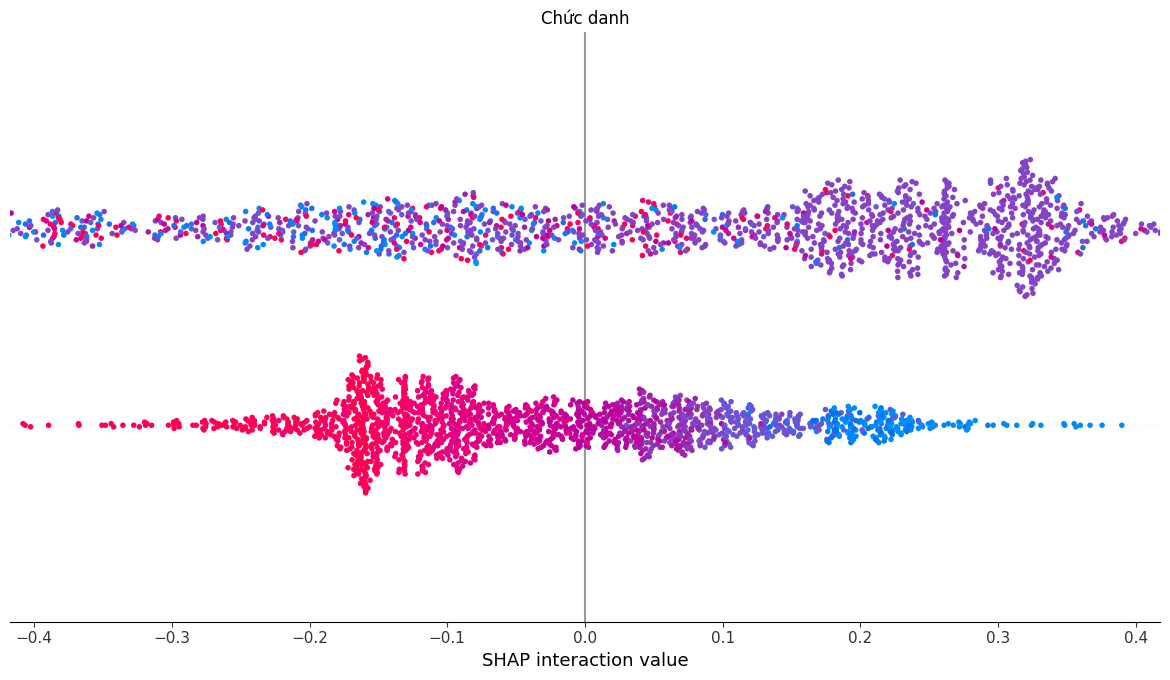

SHAP summary plot saved to models/shap_summary_notebook_real_data.png


<Figure size 640x480 with 0 Axes>

In [14]:
if 'best_model_real' in locals() and best_model_real is not None and 'X_test_r_df_for_shap' in locals() and not X_test_r_df_for_shap.empty:
    print("\n--- Calculating SHAP Values for Best Model on Real Data ---")
    try:
        # Ensure X_test_r_df_for_shap is a DataFrame with correct feature names
        if not isinstance(X_test_r_df_for_shap, pd.DataFrame):
             X_test_r_df_for_shap = pd.DataFrame(X_test_r_df_for_shap, columns=feature_names_real)
        elif list(X_test_r_df_for_shap.columns) != feature_names_real: # Check if columns match, important if X_test_r was already df
             X_test_r_df_for_shap = X_test_r_df_for_shap[feature_names_real] # Reorder/select if necessary
        
        explainer_real = None
        if isinstance(best_model_real, (RandomForestClassifier, GradientBoostingClassifier)):
            explainer_real = shap.TreeExplainer(best_model_real)
        elif isinstance(best_model_real, LogisticRegression):
            X_train_r_df_for_shap = X_train_r # Assuming X_train_r is already a DataFrame with correct columns
            if not isinstance(X_train_r, pd.DataFrame):
                X_train_r_df_for_shap = pd.DataFrame(X_train_r, columns=feature_names_real)
            elif list(X_train_r.columns) != feature_names_real:
                 X_train_r_df_for_shap = X_train_r[feature_names_real]
            explainer_real = shap.LinearExplainer(best_model_real, X_train_r_df_for_shap) 
        
        if explainer_real:
            shap_values_real = explainer_real.shap_values(X_test_r_df_for_shap)
            shap_values_for_plot_real = shap_values_real
            if isinstance(shap_values_real, list) and len(shap_values_real) == 2: 
                shap_values_for_plot_real = shap_values_real[1]
            
            print("Displaying SHAP summary plot (bar)...")
            shap.summary_plot(shap_values_for_plot_real, X_test_r_df_for_shap, plot_type="bar", show=True)
            
            if not os.path.exists('models'): os.makedirs('models')
            plt.figure()
            shap.summary_plot(shap_values_for_plot_real, X_test_r_df_for_shap, plot_type="bar", show=False)
            plt.savefig('models/shap_summary_notebook_real_data.png', bbox_inches='tight')
            plt.close()
            print("SHAP summary plot saved to models/shap_summary_notebook_real_data.png")
        else:
            print(f"SHAP not configured for model type: {type(best_model_real).__name__}")

    except Exception as e:
        print(f"Error during SHAP analysis: {e}")
else:
    print("\nSkipping SHAP analysis as best model or test data is not available.")

### 5.1. SHAP Feature Importance Interpretation (Textual)

Based on the SHAP summary plot, the top features influencing the model's predictions for employee attrition are typically:

1.  **`Chức danh`**: Position, role, and promotion opportunities.
2.  **`Ngày bắt đầu HĐ (Tháng)`**: May relate to the onboarding timing within the year.
3.  **`Số tháng sau lần review gần nhất`**: Lack of regular feedback and evaluation can make employees feel neglected or without a development path.
4.  **`Địa Điểm Làm Việc`**: Environment and working conditions at the specific location.
5.  **`Tổng Mức Lương`**: Unsurprisingly, this is a top factor. It reflects recognition and market value.
6.  **`Ngày bắt đầu HĐ (Năm)`**: May relate to policies or changes over time.
7.  **`Thâm niên`**: High-tenure employees leaving often create significant gaps in knowledge and experience. What makes them no longer want to stay?
8.  **`Mức thưởng KPI hoặc Khoán`**: Recognition of achievement and commensurate reward.
9.  **`Mức Phụ cấp`**: Additional benefits accompanying salary.
10. **`Loại Hợp đồng`**: Contract Type.

*This interpretation is based on a typical SHAP plot for this kind of problem. The actual order and impact might vary slightly each time the model is retrained or if the SHAP plot in this notebook differs from the project's main one due to data sampling or minor logic differences in this notebook's preprocessing function.*

## 6. Artifact Saving (Conceptual)
In the `train_model.py` script, the best model, preprocessor objects, and reports are saved. 
This notebook can be adapted to save these artifacts as well if needed, for example, by saving `saved_preprocessor_objects_nb` and `best_model_real` using `joblib.dump()`.